# Business Understanding

# Data Understanding

# Data Preparation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import re
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
import pandas as pd

vaccine = pd.read_csv('data/training_set_features.csv')
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
vaccine_label = pd.read_csv('data/training_set_labels.csv')
vaccine_label.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [4]:
vaccine = vaccine.merge(vaccine_label, on='respondent_id')

In [5]:
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [6]:
vaccine.drop(columns='seasonal_vaccine',inplace=True)

In [7]:
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [8]:
vaccine.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine'],
      dtype='object')

In [9]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [10]:
vaccine.drop(columns=['respondent_id', 'doctor_recc_seasonal','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc',
                     'employment_industry','employment_occupation'], inplace=True)

In [11]:
vaccine.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0


In [12]:
vaccine.drop(columns=['h1n1_knowledge','behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask','behavioral_outside_home',
                     'behavioral_touch_face','chronic_med_condition','rent_or_own'], inplace=True)

In [13]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   behavioral_wash_hands        26665 non-null  float64
 2   behavioral_large_gatherings  26620 non-null  float64
 3   doctor_recc_h1n1             24547 non-null  float64
 4   child_under_6_months         25887 non-null  float64
 5   health_worker                25903 non-null  float64
 6   health_insurance             14433 non-null  float64
 7   opinion_h1n1_vacc_effective  26316 non-null  float64
 8   opinion_h1n1_risk            26319 non-null  float64
 9   opinion_h1n1_sick_from_vacc  26312 non-null  float64
 10  age_group                    26707 non-null  object 
 11  education                    25300 non-null  object 
 12  race                         26707 non-null  object 
 13  sex             

In [14]:
vaccine.groupby(['h1n1_vaccine','health_insurance'])['health_insurance'].count()

h1n1_vaccine  health_insurance
0             0.0                 1480
              1.0                 8663
1             0.0                  256
              1.0                 4034
Name: health_insurance, dtype: int64

In [15]:
vaccine['health_insurance'].isna().sum()

12274

In [16]:
vaccine.drop(columns=['health_insurance'],inplace=True)

In [17]:
vaccine.head()

,h1n1_concern,behavioral_wash_hands,behavioral_large_gatherings,doctor_recc_h1n1,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,age_group,...,race,sex,income_poverty,marital_status,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,55 - 64 Years,...,White,Female,Below Poverty,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0
1,3.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,35 - 44 Years,...,White,Male,Below Poverty,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0
2,1.0,0.0,0.0,NaN,0.0,0.0,3.0,1.0,1.0,18 - 34 Years,...,White,Male,"<= $75,000, Above Poverty",Not Married,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0
3,1.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,65+ Years,...,White,Female,Below Poverty,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0
4,2.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,45 - 54 Years,...,White,Female,"<= $75,000, Above Poverty",Married,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0


In [18]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   behavioral_wash_hands        26665 non-null  float64
 2   behavioral_large_gatherings  26620 non-null  float64
 3   doctor_recc_h1n1             24547 non-null  float64
 4   child_under_6_months         25887 non-null  float64
 5   health_worker                25903 non-null  float64
 6   opinion_h1n1_vacc_effective  26316 non-null  float64
 7   opinion_h1n1_risk            26319 non-null  float64
 8   opinion_h1n1_sick_from_vacc  26312 non-null  float64
 9   age_group                    26707 non-null  object 
 10  education                    25300 non-null  object 
 11  race                         26707 non-null  object 
 12  sex                          26707 non-null  object 
 13  income_poverty  

In [19]:
vaccine['doctor_recc_h1n1'] = vaccine['doctor_recc_h1n1'].fillna(0.0)

In [20]:
vaccine['income_poverty'] = vaccine['income_poverty'].fillna('<= $75,000, Above Poverty')

In [21]:
#vaccine['rent_or_own'] = vaccine['rent_or_own'].fillna('Own')

In [22]:
vaccine = vaccine.dropna(how='any',axis=0)

In [23]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24658 entries, 0 to 26706
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24658 non-null  float64
 1   behavioral_wash_hands        24658 non-null  float64
 2   behavioral_large_gatherings  24658 non-null  float64
 3   doctor_recc_h1n1             24658 non-null  float64
 4   child_under_6_months         24658 non-null  float64
 5   health_worker                24658 non-null  float64
 6   opinion_h1n1_vacc_effective  24658 non-null  float64
 7   opinion_h1n1_risk            24658 non-null  float64
 8   opinion_h1n1_sick_from_vacc  24658 non-null  float64
 9   age_group                    24658 non-null  object 
 10  education                    24658 non-null  object 
 11  race                         24658 non-null  object 
 12  sex                          24658 non-null  object 
 13  income_poverty       

In [24]:
doc_rec = vaccine[vaccine['doctor_recc_h1n1']==1].groupby('h1n1_vaccine')[['doctor_recc_h1n1']].count().sort_values(by='doctor_recc_h1n1',
                                                                                              ascending=False)

In [25]:
doc_rec.reset_index(inplace=True)

In [26]:
def bar_graph(x,y,df,title,xlabel,ylabel):

    plt.figure(figsize=(14, 6))

    ax1 = sns.barplot(x=x,  y=y, data=df, color='darkblue')

    ax1.bar_label(ax1.containers[0],size=16)
    # show the graph

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel(ylabel,fontsize=18)
    plt.tick_params(axis='y',labelsize=16)
    plt.tick_params(axis='x',labelsize=16)
    plt.show()

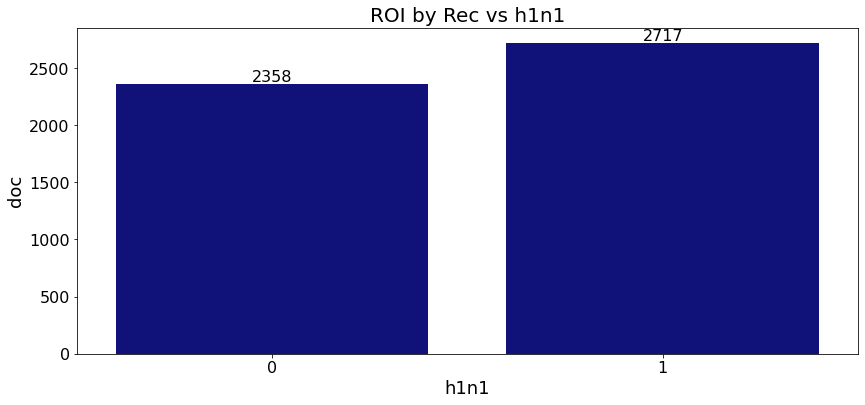

In [27]:
bar_graph('h1n1_vaccine','doctor_recc_h1n1',doc_rec,'Rec vs h1n1', 'h1n1', 'doc')

In [28]:
health_work = vaccine[vaccine['health_worker'] == 1].groupby('h1n1_vaccine')[['health_worker']].count().sort_values(by='health_worker',
                                                                                              ascending=False)

In [29]:
health_work.reset_index(inplace=True)

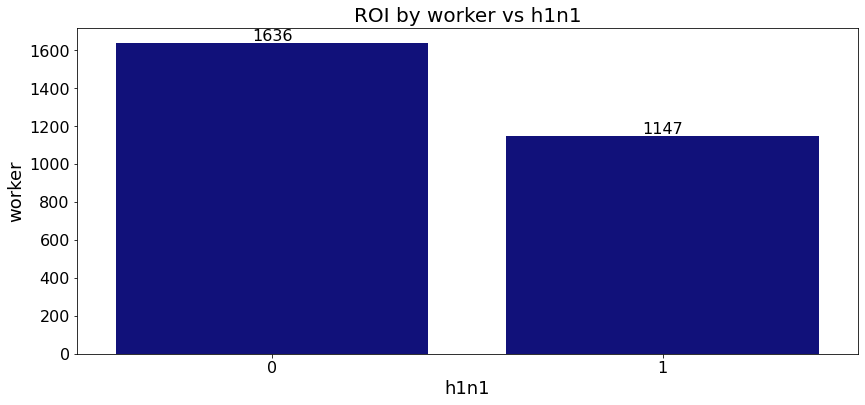

In [30]:
bar_graph('h1n1_vaccine','health_worker',health_work,'worker vs h1n1', 'h1n1', 'worker')

In [31]:
risk = vaccine.copy()

In [32]:
risk = risk[risk['opinion_h1n1_risk']!=3.0]

In [34]:
risk['opinion_h1n1_risk'] = risk['opinion_h1n1_risk'].apply(lambda x: 'high risk' if x > 3 else 'low risk')

In [35]:
risk = risk[risk['h1n1_vaccine']==1].groupby('opinion_h1n1_risk')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine',
                                                                                              ascending=False)

In [36]:
risk.reset_index(inplace=True)

In [37]:
risk

,opinion_h1n1_risk,h1n1_vaccine
0,high risk,2882
1,low risk,2251


In [38]:
risk['opinion_h1n1_risk'] = risk['opinion_h1n1_risk'].astype(str)

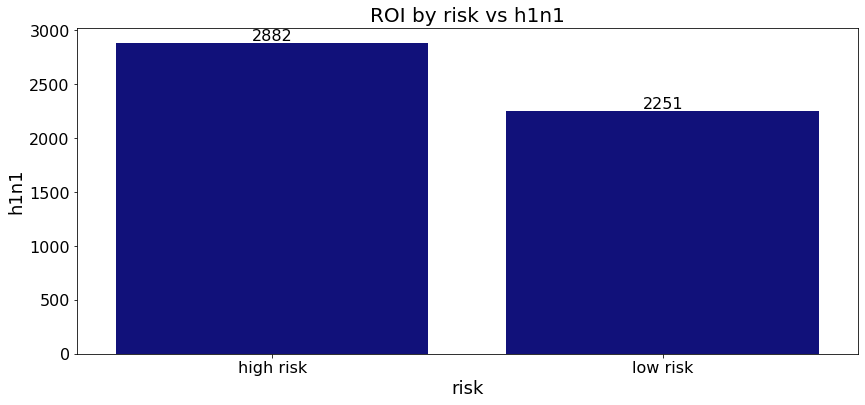

In [39]:
bar_graph('opinion_h1n1_risk','h1n1_vaccine', risk, 'risk vs h1n1', 'risk', 'h1n1')

# Exploratory Data Analysis

# Model

In [900]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24658 entries, 0 to 26706
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24658 non-null  float64
 1   behavioral_wash_hands        24658 non-null  float64
 2   behavioral_large_gatherings  24658 non-null  float64
 3   doctor_recc_h1n1             24658 non-null  float64
 4   child_under_6_months         24658 non-null  float64
 5   health_worker                24658 non-null  float64
 6   opinion_h1n1_vacc_effective  24658 non-null  float64
 7   opinion_h1n1_risk            24658 non-null  float64
 8   opinion_h1n1_sick_from_vacc  24658 non-null  float64
 9   age_group                    24658 non-null  object 
 10  education                    24658 non-null  object 
 11  race                         24658 non-null  object 
 12  sex                          24658 non-null  object 
 13  income_poverty       

In [901]:
#Class imbalance

vaccine['h1n1_vaccine'].value_counts(normalize=True)

h1n1_vaccine
0    0.785303
1    0.214697
Name: proportion, dtype: float64

In [902]:

vaccine['household_adults'] = vaccine['household_adults'].apply(lambda x: 'other adults' if x >= 1 else 'no other adults')
vaccine['household_children'] = vaccine['household_children'].apply(lambda x: 'children' if x >= 1 else 'no children')
    

In [903]:
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24658 entries, 0 to 26706
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24658 non-null  float64
 1   behavioral_wash_hands        24658 non-null  float64
 2   behavioral_large_gatherings  24658 non-null  float64
 3   doctor_recc_h1n1             24658 non-null  float64
 4   child_under_6_months         24658 non-null  float64
 5   health_worker                24658 non-null  float64
 6   opinion_h1n1_vacc_effective  24658 non-null  float64
 7   opinion_h1n1_risk            24658 non-null  float64
 8   opinion_h1n1_sick_from_vacc  24658 non-null  float64
 9   age_group                    24658 non-null  object 
 10  education                    24658 non-null  object 
 11  race                         24658 non-null  object 
 12  sex                          24658 non-null  object 
 13  income_poverty       

In [904]:
encoded_cols = []

for col in vaccine.columns:
    if vaccine[col].dtype == 'O':
        encoded_cols.append(col)
        
encoded_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [905]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np


def encoding(data):

    encoded_vaccine = pd.DataFrame()

    for col in encoded_cols:
    
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

        ohe.fit(data[[col]])

        vaccine_ohe = pd.DataFrame(
            ohe.transform(data[[col]]),
            index= data.index,
            columns=np.hstack(ohe.categories_)
        )
    
        col_dict = {}
        for col in vaccine_ohe.columns:
            col_dict[col] = vaccine_ohe[col].sum()
    
    
        
        minimum = [k for k,v in col_dict.items() if v == min(col_dict.values())]
    
    
        vaccine_ohe.drop(columns=minimum, inplace = True)
    
    
        encoded_vaccine = pd.concat([encoded_vaccine,vaccine_ohe], axis=1)
        

    data.drop(columns=encoded_cols,inplace = True)
    data = pd.concat([data, encoded_vaccine],axis=1)   

    return data

In [906]:
# Import the relevant function
from sklearn.model_selection import train_test_split
# Define our X and y
X = vaccine.drop(columns = ['h1n1_vaccine'], axis=1)
y = vaccine['h1n1_vaccine']

In [907]:
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [908]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all)

In [909]:
X.head()

,h1n1_concern,behavioral_wash_hands,behavioral_large_gatherings,doctor_recc_h1n1,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,employment_status,hhs_geo_region,census_msa,household_adults,household_children
0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,no other adults,no children
1,3.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",no other adults,no children
2,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Employed,qufhixun,"MSA, Not Principle City",other adults,no children
3,1.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,5.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",no other adults,no children
4,2.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Employed,qufhixun,"MSA, Not Principle City",other adults,no children


In [910]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: h1n1_vaccine, dtype: int64

In [911]:
print("Train percent:", y_train.value_counts(normalize=True)[1])
print("Valid percent: ", y_valid.value_counts(normalize=True)[1])
print("Hold percent: ", y_hold_out.value_counts(normalize=True)[1])

Train percent: 0.21472427195403593
Valid percent:  0.21468799279116918
Hold percent:  0.21451743714517438


In [912]:
X_train = encoding(X_train)
X_valid = encoding(X_valid)
X_hold_out = encoding(X_hold_out)

<ipython-input-905-ac948b23a204>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=encoded_cols,inplace = True)
<ipython-input-905-ac948b23a204>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=encoded_cols,inplace = True)
<ipython-input-905-ac948b23a204>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=encoded_cols,inplace = True)


In [913]:
X_train

,h1n1_concern,behavioral_wash_hands,behavioral_large_gatherings,doctor_recc_h1n1,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,18 - 34 Years,...,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun,"MSA, Not Principle City","MSA, Principle City",other adults,no children
2157,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
14761,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
585,1.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6348,2.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
19432,2.0,1.0,1.0,0.0,0.0,0.0,4.0,5.0,4.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23450,1.0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
16550,2.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17193,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
12362,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [914]:


# Import relevant class and function
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Instantiate a LogisticRegression with random_state=42
baseline_model = LogisticRegression(max_iter=200)
baseline_model.fit(X_train,y_train)


# Use cross_val_score with scoring="recall" or "f1" to evaluate the model
# on X_train and y_train

baseline_recall_logreg = cross_validate(baseline_model, X_train, y_train, scoring="recall", return_train_score=True)
baseline_f1_logreg = cross_validate(baseline_model, X_train, y_train, scoring="f1", return_train_score=True)



print(np.mean(baseline_recall_logreg['test_score']))
print(np.mean(baseline_recall_logreg['train_score']))
print('\n')
print(np.mean(baseline_f1_logreg['test_score']))
print(np.mean(baseline_f1_logreg['train_score']))

0.4239302655975343
0.42674463543542895
/n
0.5237681968145713
0.528367371625545


In [915]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.407215
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           h1n1_vaccine   No. Observations:                17753
Model:                          Logit   Df Residuals:                    17715
Method:                           MLE   Df Model:                           37
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                  0.2171
Time:                        14:43:20   Log-Likelihood:                -7229.3
converged:                       True   LL-Null:                       -9234.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
h1n1_concern                   -0.1269      0.028     -4.517      0.000   

In [916]:
np.exp(result.params)

h1n1_concern                   0.880807
behavioral_wash_hands          0.860887
behavioral_large_gatherings    0.755587
doctor_recc_h1n1               5.911302
child_under_6_months           1.169595
health_worker                  2.445227
opinion_h1n1_vacc_effective    1.459286
opinion_h1n1_risk              1.582416
opinion_h1n1_sick_from_vacc    0.911481
18 - 34 Years                  0.630298
45 - 54 Years                  0.751691
55 - 64 Years                  1.189539
65+ Years                      1.287140
12 Years                       0.644261
College Graduate               0.786602
Some College                   0.674646
Black                          0.256359
Hispanic                       0.324514
White                          0.426456
Female                         0.808923
<= $75,000, Above Poverty      0.684920
> $75,000                      0.823185
Married                        1.185485
Employed                       0.428320
Not in Labor Force             0.471325


In [917]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [918]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Use cross_val_score with scoring="recall" or "f1" to evaluate the model
# on X_train and y_train
baseline_recall_dt = cross_validate(dt, X_train, y_train, scoring="recall", return_train_score=True)
baseline_f1_dt = cross_validate(dt, X_train, y_train, scoring="f1",return_train_score=True)

print(np.mean(baseline_recall_dt['test_score']))
print(np.mean(baseline_recall_dt['train_score']))
print('\n')
print(np.mean(baseline_f1_dt['test_score']))
print(np.mean(baseline_f1_dt['train_score']))


0.4774436452324194
0.9961962696718623
/n
0.45605841413930237
0.9980944611990589


In [919]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

baseline_recall_rfc = cross_validate(rfc, X_train, y_train, scoring="recall", return_train_score=True)
baseline_f1_rfc = cross_validate(rfc, X_train, y_train, scoring="f1", return_train_score=True)


print(np.mean(baseline_recall_rfc['test_score']))
print(np.mean(baseline_recall_rfc['train_score']))
print('\n')
print(np.mean(baseline_f1_rfc['test_score']))
print(np.mean(baseline_f1_rfc['train_score']))


0.4074010244132327
0.9969832409443569
/n
0.5092391691086292
0.9980310436342906


In [937]:
logreg_model = LogisticRegression(max_iter=200, random_state=42, C=1, class_weight='balanced',solver='lbfgs')
logreg_model.fit(X_train,y_train)


# Use cross_val_score with scoring="recall" or "f1" to evaluate the model
# on X_train and y_train

baseline_recall_logreg = cross_validate(logreg_model, X_train, y_train, scoring="recall", return_train_score=True)
baseline_recall_logreg_val = cross_validate(logreg_model, X_valid, y_valid, scoring="recall", return_train_score=True)
baseline_f1_logreg = cross_validate(logreg_model, X_train, y_train, scoring="f1",return_train_score=True)
baseline_f1_logreg_val = cross_validate(logreg_model, X_valid, y_valid, scoring="f1",return_train_score=True)


print(np.mean(baseline_recall_logreg['test_score']))
print(np.mean(baseline_recall_logreg['train_score']))
print('\n')
print(np.mean(baseline_recall_logreg_val['test_score']))
print(np.mean(baseline_recall_logreg_val['train_score']))
print('\n')
print('\n')
print(np.mean(baseline_f1_logreg['test_score']))
print(np.mean(baseline_f1_logreg['train_score']))
print('\n')
print(np.mean(baseline_f1_logreg_val['test_score']))
print(np.mean(baseline_f1_logreg_val['train_score']))


0.724296274892244
0.7308501040384108


0.7156406723615321
0.7337364939474308




0.5789860185621014
0.5830161841433951


0.5769309198116785
0.5890320622637384


In [923]:
final_model = logreg_model
final_model.fit(X_train,y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=200, random_state=42)

In [924]:
recall_score(y_hold_out, final_model.predict(X_hold_out))

0.6994328922495274

In [929]:
f1_score(y_hold_out, final_model.predict(X_hold_out))

0.5653170359052712

In [925]:
y_pred_new_threshold = (final_model.predict_proba(X_hold_out)[:, 1] >= 0.35).astype(int) 

In [926]:
print("Recall:  ", recall_score(y_hold_out, y_pred_new_threshold))
print("f1:  ", f1_score(y_hold_out, y_pred_new_threshold))

Recall:   0.833648393194707
f1:   0.516091281451141


In [927]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Print confusion matrix
cnf_matrix = confusion_matrix(y_hold_out, y_pred_new_threshold)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[1198  739]
 [  88  441]]


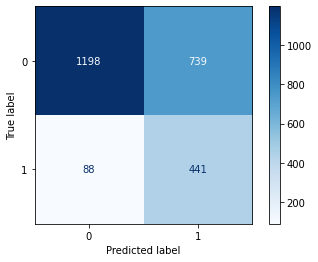

In [928]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Conclusion

## Limitations

## Recommendations

## Next Steps